In [1]:
#pip install pyldavis
#pip install python-Levenshtein
#!{sys.executable} -m pip install spacy
#!{sys.executable} -m spacy download en

In [2]:
import sys
import spacy
import numpy as np
import pandas as pd
import re, nltk, gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline


Read the data from csv file

In [3]:
df = pd.read_csv('merge_data_stackoverflow.csv', error_bad_lines=False)
df = df.dropna(subset=['Question'])

showing the output file and its column

In [4]:
print(len(df)) #it will give the total number of questions
df.head(499)#it will show the data

10000


,Question Title,Question,Tags,Question_User_Id,Answer_User_Id
0,how to get geofense request id in geotrasition...,"<p>Here i put geofense logic for create,start,...","java,android,geofencing",57180856,0
1,How can I add Default list in dropdown then us...,<p>I've created a dropdown list that is filter...,"dropdown,ssrs-2012,searchable",57175633,57181115
2,Find LDAP user in nested group through Java,<p>Nothing I've found is working for me. And I...,"java,active-directory,ldap",56998316,0
3,Oracle Forms Messages are not Shown Except Sta...,<p>I want to show custom messages in my form. ...,"oracle,oracleforms",57141375,0
4,React-DatePicker - Format not Defined,<p>I Tried to Implement React Datepicker Funct...,"reactjs,react-datepicker",56889104,56889677
...,...,...,...,...,...
494,Angular Material Design : Radio button group t...,<p>Below is the angular material code i am usi...,"javascript,css,angular,typescript,angular-mate...",56926142,0
495,it is possible to embed a private report into ...,<p>We're trying to embed a GDS private report ...,"google-cloud-platform,google-bigquery,google-d...",57072874,0
496,How to clear multiple youtube url of iframe ta...,<p>I have a modal pop up in which I am display...,"asp.net,youtube,modal-dialog",56903329,0
497,Fixed div on mobile is not fixed,<p>I need to have an action bar fixed to the b...,"html,css,mobile",57196940,64843972


Data cleaning

In [5]:
# Convert to list
data = df.Question.values.tolist()

# Remove Emails
data = [re.sub(r'\S*@\S*\s?', '', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub(r'\s+', ' ', sent) for sent in data]
data = [re.sub(r"\'", "", sent) for sent in data]
data = [re.sub(r"</p>", "", sent) for sent in data]
data = [re.sub(r"<p>", "", sent) for sent in data]
data = [re.sub(r"<code>", "", sent) for sent in data]
data = [re.sub(r"</code>", "", sent) for sent in data]
data = [re.sub(r"</pre>", "", sent) for sent in data]
data = [re.sub(r"<pre>", "", sent) for sent in data]
 
#print(data[:1])

Tokenization

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(data))
print(data_words[:1])

[['here', 'put', 'geofense', 'logic', 'for', 'create', 'start', 'remove', 'clear', 'geofense', 'but', 'want', 'to', 'get', 'request', 'id', 'to', 'do', 'some', 'task', 'on', 'id', 'when', 'it', 'enter', 'in', 'range', 'activity', 'start', 'geofence', 'creation', 'process', 'private', 'void', 'startgeofence', 'log', 'tag', 'startgeofence', 'if', 'geofencemarker', 'null', 'geofence', 'geofence', 'creategeofence', 'geofencemarker', 'getposition', 'geofence_radius', 'geofencerequest', 'geofence', 'addgeofence', 'geofencerequest', 'else', 'log', 'tag', 'geofence', 'marker', 'is', 'null', 'private', 'static', 'final', 'long', 'geo_duration', 'private', 'static', 'final', 'string', 'geofence_req_id', 'my', 'geofence', 'private', 'static', 'final', 'float', 'geofence_radius', 'in', 'meters', 'create', 'geofence', 'private', 'geofence', 'creategeofence', 'latlng', 'latlng', 'float', 'radius', 'string', 'uid', 'uuid', 'randomuuid', 'tostring', 'log', 'tag', 'creategeofence', 'return', 'new', 'ge

Stemming

In [7]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): #'NOUN', 'ADJ', 'VERB', 'ADV'
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [8]:
# Initialize spacy ‘en’ model, keeping only tagger component (for efficiency)
# Run in terminal: python -m spacy download en
nlp = spacy.load("en_core_web_sm")
# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']) 
#select Noun, Adj, Verb, Adverb
print(data_lemmatized[:9])

['here put geofense logic create start remove clear geofense want get request d do task d when enter range activity start geofence creation process private void startgeofence log tag startgeofence geofencemarker null geofence geofence creategeofence geofencemarker getposition geofence_radius geofencerequest geofence addgeofence geofencerequest else log tag geofence marker be null private static final long geo_duration private static final string geofence_req_id geofence private static final float geofence_radius meter create geofence private geofence creategeofence latlng latlng float radius string uid uuid randomuuid tostring log tag creategeofence return new geofence builder setrequestid uid latlng latitude latlng longitude radius geo_duration geofence geofence build create geofence request private geofence geofence log tag return new builder addgeofence geofence build private pendingintent private final int private pendingintent log tag null return intent intent new intent class ret

Create the Document-Word matrix

In [9]:
vectorizer = CountVectorizer(analyzer='word',min_df=10,stop_words='english',lowercase=True,token_pattern='[a-zA-Z0-9]{3,}')
data_vectorized = vectorizer.fit_transform(data_lemmatized)

Build LDA model with sklearn

In [10]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               
# Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          
# Random state
                                      batch_size=128,            
# n docs in each learning iter
                                      evaluate_every = -1,       
# compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               
# Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)
print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', n_components=20, n_jobs=-1,
                          random_state=100)


 Diagnose model performance with perplexity and log-likelihood

In [11]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))
# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -7349900.873798868
Perplexity:  524.5562387324456
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


Use GridSearch to determine the best LDA model.

In [12]:
# Define Search Param
search_params = {'n_components': [3], 'learning_decay': [float(.5), float(.7), float(.9)]}
# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50,random_state=0)
# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)
# Do the Grid Search
model.fit(data_vectorized)
GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
              perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
      iid=bool(True), n_jobs=1,
       param_grid={'n_topics': [3], 'learning_decay': [float(.5), float(.7), float(.9)]},
       pre_dispatch='2*n_jobs', refit=bool(True), return_train_score='warn',
       scoring=None, verbose=0)

C:\Users\ashu\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:443: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
C:\Users\ashu\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:93: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for 

GridSearchCV(error_score='raise',
             estimator=LatentDirichletAllocation(learning_method=None,
                                                 n_jobs=1),
             iid=True, n_jobs=1,
             param_grid={'learning_decay': [0.5, 0.7, 0.9], 'n_topics': [3]},
             return_train_score='warn')

In [13]:
# Best Model
best_lda_model = model.best_estimator_
# Model Parameters
print("Best Model's Params: ", model.best_params_)
# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)
# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 3}
Best Log Likelihood Score:  -1584582.5417850607
Model Perplexity:  743.7041895978797


Dominant topic

In [14]:
def print_topics(model, vectorizer, top_n=40):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])
 
print("LDA Model:")
print_topics(best_lda_model, vectorizer)
print("=" * 20)
 

LDA Model:
Topic 0:
[('https', 8196.562722288725), ('class', 7891.703573598004), ('use', 7263.627160706393), ('com', 7093.673572204223), ('strong', 5940.213508285855), ('href', 5561.247253138428), ('datum', 4921.883787097474), ('return', 4806.032598417336), ('code', 4775.7843637682345), ('rel', 4604.7848831402025), ('div', 4493.971737684829), ('try', 4360.806466399685), ('new', 4345.151056949095), ('value', 4231.639700551101), ('string', 4193.26093636682), ('stack', 4085.021470398219), ('text', 4028.509153677629), ('image', 3966.271512908518), ('nofollow', 3913.397930393065), ('imgur', 3913.1530213425444), ('noreferrer', 3873.1141941598275), ('png', 3754.3421195954643), ('import', 3521.9895654343177), ('work', 3339.5905838918848), ('amp', 3264.5097664953514), ('function', 3244.176335595505), ('want', 2834.2585597553884), ('type', 2814.260320482471), ('list', 2659.4979999298266), ('page', 2652.1115810015576), ('true', 2630.325405418096), ('html', 2612.0169001656727), ('public', 2602.603

In [15]:
# Create Document — Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)
# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]
# index names
docnames = ["Doc" + str(i) for i in range(len(data))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic["dominant_topic"] = dominant_topic
# Styling
def color_green(val):
 color = "green" if val > .1 else 'black'
 return 'color: {col}'.format(col=color)
def make_bold(val):
 weight = 700 if val > .1 else 400
 return 'font-weight: {weight}'.format(weight=weight)
# Apply Style
df_document_topics = df_document_topic.head(499).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,dominant_topic
Doc0,1.000000,0.000000,0.000000,0
Doc1,0.970000,0.010000,0.010000,0
Doc2,0.890000,0.110000,0.000000,0
Doc3,0.850000,0.010000,0.140000,0
Doc4,0.960000,0.000000,0.040000,0
Doc5,0.590000,0.400000,0.010000,0
Doc6,0.120000,0.880000,0.000000,1
Doc7,0.260000,0.720000,0.020000,1
Doc8,0.720000,0.170000,0.100000,0
Doc9,0.450000,0.130000,0.430000,0


In [16]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)
# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames
# View
#df_topic_keywords.head()




def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=499)

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords.to_csv("ankitdatawrods.csv")
df_topic_keywords


In [17]:
#Guess Topics by keywords
Topics = ["1","2","3"]
df_topic_keywords["Topics"]=Topics
df_topic_keywords



,aaa,aac,abc,abcd,abi,ability,able,abort,absolute,absolutely,...,york,youtube,yyyy,zero,zip,zone,zookeeper,zoom,zsh,Topics
Topic0,17.996254,8.528850,36.443346,38.443980,0.348981,33.848130,696.652300,11.707249,87.121306,12.145542,...,27.579038,132.249060,76.272725,27.937846,36.407135,17.587491,0.338001,127.186653,0.345640,1
Topic1,5.810975,2.693403,12.519371,0.473113,57.635249,0.433409,218.689333,44.577520,7.372290,10.756735,...,0.337398,11.307940,1.134634,0.358307,180.200222,29.709447,21.329234,0.339400,22.647507,2
Topic2,30.809189,7.426008,26.075677,1.151439,0.478596,0.539061,152.663371,13.085054,5.287667,5.048982,...,0.450540,34.688291,5.991297,18.069325,31.636689,122.781350,2.015305,0.478384,0.357433,3


Predict Topics using LDA model

In [18]:
# Define function to predict topic for a given text document.
nlp = spacy.load("en_core_web_sm")
def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization
# Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))
# Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)
# Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), 1:14].values.tolist()
    
    # Step 5: Infer Topic
    infer_topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), -1]
    
    #topic_guess = df_topic_keywords.iloc[np.argmax(topic_probability_scores), Topics]
    return infer_topic, topic, topic_probability_scores
# Predict the topic
mytext = ["before/after (the) update/upgrade (to API/version/level) (14), work above/below/with API,level,android,version"]
infer_topic, topic, prob_scores = predict_topic(text = mytext)
print(topic)
print(infer_topic)

[2.6934030433677854, 12.519370930009295, 0.4731130605191743, 57.63524942695564, 0.4334094313717275, 218.6893331596806, 44.57751953099155, 7.3722897883726795, 10.756734991068251, 7.5301677825396975, 30.061658416607308, 0.4260544427433119, 0.3348901594576262]
2


Component’s weights and Percentage of Variance Explained

In [19]:
#Prediction Result of the original dataset
def apply_predict_topic(text):
 text = [text]
 infer_topic, topic, prob_scores = predict_topic(text = text)
 return(infer_topic)
df["Topic_key_word"]= df['Question'].apply(apply_predict_topic)
df.head()

,Question Title,Question,Tags,Question_User_Id,Answer_User_Id,Topic_key_word
0,how to get geofense request id in geotrasition...,"<p>Here i put geofense logic for create,start,...","java,android,geofencing",57180856,0,1
1,How can I add Default list in dropdown then us...,<p>I've created a dropdown list that is filter...,"dropdown,ssrs-2012,searchable",57175633,57181115,1
2,Find LDAP user in nested group through Java,<p>Nothing I've found is working for me. And I...,"java,active-directory,ldap",56998316,0,1
3,Oracle Forms Messages are not Shown Except Sta...,<p>I want to show custom messages in my form. ...,"oracle,oracleforms",57141375,0,1
4,React-DatePicker - Format not Defined,<p>I Tried to Implement React Datepicker Funct...,"reactjs,react-datepicker",56889104,56889677,1


In [20]:
#distribution of the prediction result.
df.groupby('Topic_key_word').nunique()

,Question Title,Question,Tags,Question_User_Id,Answer_User_Id
Topic_key_word,,,,,
1,6407,6407,5465,6407,2673
2,2016,2016,1878,2016,767
3,1577,1577,1486,1577,551


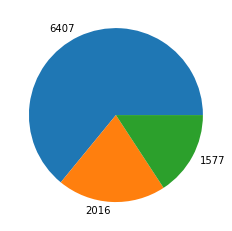

In [26]:
data = np.array([6407,2016,1577])
labels = [6407,2016,1577]

plt.pie(data, labels=labels)
plt.show()

In [34]:
#Output prediction result:
df.to_csv("topic_distribution1.csv")

In [35]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel
 

C:\Users\ashu\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:57: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\ashu\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:349: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
C:\Users\ashu\anaconda3\lib\site-packages\sklearn\ma

PreparedData(topic_coordinates=                 x            y  topics  cluster       Freq
topic                                                      
0     -1015.700562  1338.981201       1        1  47.416493
1      -387.996002  -373.316162       2        1  27.962831
2     -2184.745605   -60.565800       3        1  24.620677, topic_info=         Term          Freq         Total Category  logprob  loglift
2866     quot  67162.000000  67162.000000  Default  30.0000  30.0000
1902     java   7313.000000   7313.000000  Default  29.0000  29.0000
2504      org   5883.000000   5883.000000  Default  28.0000  28.0000
114   android   4223.000000   4223.000000  Default  27.0000  27.0000
1292     file   9396.000000   9396.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
3517   strong   1638.072952   9022.890843   Topic3  -5.1728  -0.3047
3786      try   1421.345713   7700.487655   Topic3  -5.3147  -0.2881
1646    https   1391.688909  11512.862722   Topic3  -5.3358  -0.7114
3107      run   1161.422219   6002.603544   Topic3  -5.5166  -0.2410
590      code   1141.727428   7003.673326   Topic3  -5.5337  -0.4123

[259 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
85        1  0.998436  align
96        1  0.995321    alt
96        2  0.000970    alt
96        3  0.002910    alt
106       1  0.753436    amp
...     ...       ...    ...
4069      3  0.173858   work
4119      1  0.014462    xxx
4119      3  0.983400    xxx
4127      2  0.012505   yarn
4127      3  0.987924   yarn

[482 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

In [27]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=3, random_state=100).fit_predict(lda_output)
# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)
# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]
# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))
# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

C:\Users\ashu\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:57: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\ashu\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:57: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\ashu\anaconda3\lib\site-packages\sklearn\metrics\pairwise

Component's weights: 
 [[ 0.95  0.23  0.2 ]
 [-0.28  0.91  0.32]]
Perc of Variance Explained: 
 [0.24 0.45]


C:\Users\ashu\anaconda3\lib\site-packages\scipy\linalg\decomp_qr.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
C:\Users\ashu\anaconda3\lib\site-packages\scipy\linalg\decomp_qr.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current u

Segregation of Topic Clusters

Text(0.5, 1.0, 'Segregation of Topic Clusters')

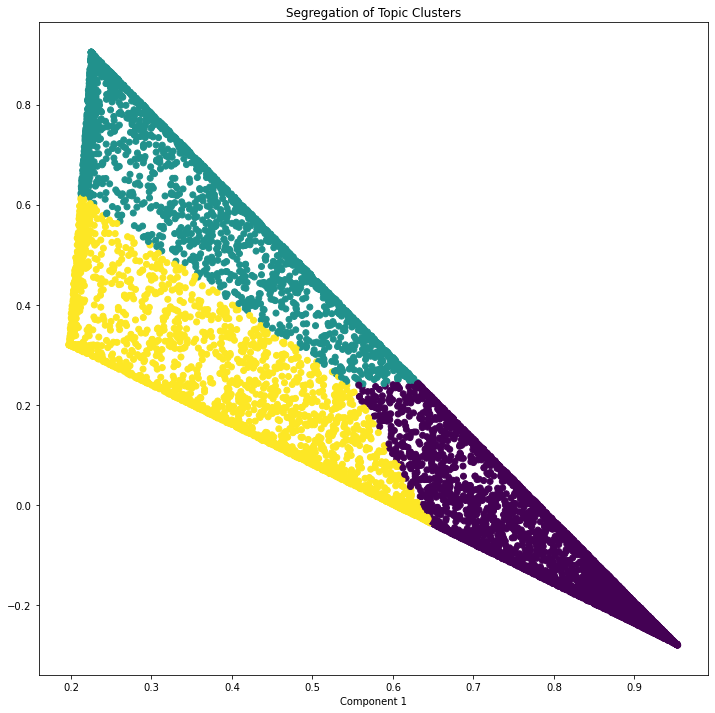

In [28]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

Once we know the probaility of topics for a given document (using predict_topic()), compute the euclidean distance with the probability scores of all other documents.
The most similar documents are the ones with the smallest distance.

Get similar documents for any given piece of text

In [36]:
from sklearn.metrics.pairwise import euclidean_distances
nlp = spacy.load("en_core_web_sm")
def similar_documents(text, doc_topic_probs, documents = data, nlp=nlp, top_n=5, verbose=False):
    y,topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [ ]:
#here you can put stackoverflow question text in mytext variable so it will give probability.
mytext = ["cloud computing "]
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = data, top_n=1, verbose=True)
print("\n", docs[0][:1])
print()